- 对图像做resize并生成相应的txt。
- 目标文件为TEXTVOC/VOC2007/，通过ln -s引入到train工程中。
- 有个线程池来写文件。

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 
import os,numpy,shutil,cv2,glob,math
import numpy as np
import xml.etree.cElementTree as ET 

In [5]:
!ls /home/lidingke/DATA/D15001JPG/006.jpg

/home/lidingke/DATA/D15001JPG/006.jpg


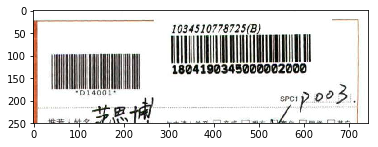

In [6]:
import random
def rd_cut_border(im):
    bcim = 255-im
    h,w,s=bcim.shape
    zeros = np.zeros((3,w,3),dtype=np.uint8)
    newim = np.vstack([zeros,bcim,zeros])
    h,w,s=newim.shape
    zeros = np.zeros((h,3,3),dtype=np.uint8)
#     print(newim.shape,zeros.shape)
    fiim = np.hstack([zeros,newim,zeros])
    ri = random.randint
    x0,x1,y0,y1 = ri(1,6),ri(1,6),ri(1,6),ri(1,6)
    fiim = fiim[x0:-x1,y0:-y1].copy()
    im = 255-fiim
#     print(im.shape,x0,x1,y0,y1)
    return im 

im0 = cv2.imread('/home/lidingke/DATA/data0419/LO0136/FD0001/1347154.JPG')
im = rd_cut_border(im0)
plt.imshow(im)


In [7]:
def generate_temp_label(stem_name, original_size_r, resized_size_r,xml_labels_r, xml_points):
    #在xml文件中坐标位置的基础上，再向外扩展的像素数
    lv_biases = 4
    for i in range(len(xml_points)):
        x1 = xml_points[i][0]
        y1 = xml_points[i][1]
        x2 = xml_points[i][2]
        y2 = xml_points[i][1]
        x3 = xml_points[i][2]
        y3 = xml_points[i][3]
        x4 = xml_points[i][0]
        y4 = xml_points[i][3]
        label = xml_labels_r[i][0]
        
        pt_x = np.zeros((4, 1))
        pt_y = np.zeros((4, 1))
        
        pt_x[0, 0] = int(float(x1) / original_size_r[1] * resized_size_r[1])
        pt_y[0, 0] = int(float(y1) / original_size_r[0] * resized_size_r[0])
        pt_x[1, 0] = int(float(x2) / original_size_r[1] * resized_size_r[1])
        pt_y[1, 0] = int(float(y2) / original_size_r[0] * resized_size_r[0])
        pt_x[2, 0] = int(float(x3) / original_size_r[1] * resized_size_r[1])
        pt_y[2, 0] = int(float(y3) / original_size_r[0] * resized_size_r[0])
        pt_x[3, 0] = int(float(x4) / original_size_r[1] * resized_size_r[1])
        pt_y[3, 0] = int(float(y4) / original_size_r[0] * resized_size_r[0])

        pt_x[0, 0] = pt_x[0, 0] - lv_biases
        if pt_x[0, 0] < 0:
            pt_x[0, 0] = 0        
        pt_y[0, 0] = pt_y[0, 0] - lv_biases
        if pt_y[0, 0] < 0:
            pt_y[0, 0] = 0
        pt_x[1, 0] = pt_x[1, 0] + lv_biases
        if pt_x[1, 0] > resized_size_r[1]:
            pt_x[1, 0] = resized_size_r[1]         
        pt_y[1, 0] = pt_y[1, 0] - lv_biases
        if pt_y[1, 0] < 0:
            pt_y[1, 0] = 0              
        pt_x[2, 0] = pt_x[2, 0] - lv_biases
        if pt_x[2, 0] < 0:
            pt_x[2, 0] = 0 
        pt_y[2, 0] = pt_y[2, 0] + lv_biases
        if pt_y[2, 0] > resized_size_r[0]:
            pt_y[2, 0] = resized_size_r[0]         
        pt_x[3, 0] = pt_x[3, 0] + lv_biases
        if pt_x[3, 0] > resized_size_r[1]:
            pt_x[3, 0] = resized_size_r[1]         
        pt_y[3, 0] = pt_y[3, 0] + lv_biases
        if pt_y[3, 0] > resized_size_r[0]:
            pt_y[3, 0] = resized_size_r[0]  

        ind_x = np.argsort(pt_x, axis=0)
        pt_x = pt_x[ind_x]
        pt_y = pt_y[ind_x]

        if pt_y[0] < pt_y[1]:
            pt1 = (pt_x[0], pt_y[0])
            pt3 = (pt_x[1], pt_y[1])
        else:
            pt1 = (pt_x[1], pt_y[1])
            pt3 = (pt_x[0], pt_y[0])

        if pt_y[2] < pt_y[3]:
            pt2 = (pt_x[2], pt_y[2])
            pt4 = (pt_x[3], pt_y[3])
        else:
            pt2 = (pt_x[3], pt_y[3])
            pt4 = (pt_x[2], pt_y[2])

        xmin = int(min(pt1[0], pt2[0]))
        ymin = int(min(pt1[1], pt2[1]))
        xmax = int(max(pt2[0], pt4[0]))
        ymax = int(max(pt3[1], pt4[1]))

        width = xmax - xmin
        height = ymax - ymin

        # reimplement
        step = 16.0
        x_left = []
        x_right = []
        x_left.append(xmin)
        x_left_start = int(math.ceil(xmin / 16.0) * 16.0)
        if x_left_start == xmin:
            x_left_start = xmin + 16
        for i in np.arange(x_left_start, xmax, 16):
            x_left.append(i)
        x_left = np.array(x_left)

        x_right.append(x_left_start - 1)
        for i in range(1, len(x_left) - 1):
            x_right.append(x_left[i] + 15)
        x_right.append(xmax)
        x_right = np.array(x_right)

        idx = np.where(x_left == x_right)
        x_left = np.delete(x_left, idx, axis=0)
        x_right = np.delete(x_right, idx, axis=0)

        with open(os.path.join(Temp_Label_Path, stem_name) + '.txt', 'a') as f:
            for i in range(len(x_left)):
                if label == 'dontcare':
                    f.writelines("dontcare\t")
                    print(Temp_Label_Path,stem_name)
                else:
                    f.writelines("text\t")
                f.writelines(str(int(x_left[i])))
                f.writelines("\t")
                f.writelines(str(int(ymin)))
                f.writelines("\t")
                f.writelines(str(int(x_right[i])))
                f.writelines("\t")
                f.writelines(str(int(ymax)))
                f.writelines("\n")

In [32]:
%%time
import os,numpy,shutil,cv2,glob,math
import numpy as np
import xml.etree.cElementTree as ET 

ROOT_PATH = '/home/lidingke/DATA/hw_0807r'
#单位电话原始图片位置
Original_Image_Path = os.path.join(ROOT_PATH,'JPEGImages')
#单位电话原始图片的xml文件位置
Original_Label_Path = os.path.join(ROOT_PATH,'Annotations')

#Resize之后图片保存的目录
Resized_Image_Path = os.path.join(ROOT_PATH,'image_resized')
#生成临时文件目录,文件名为:aaa.txt,格式:text    104     26      111     111
#每个bbox的坐标，左上 右下
Temp_Label_Path = os.path.join(ROOT_PATH,'label_temp')

def generate_resized_image(filename,stem_name):
    #print filename
    _, basename = os.path.split(filename)
#     stem_name = basename.split('.')[0]+random_num
    original_img = cv2.imread(filename)
    original_img = rd_cut_border(original_img)
    if not isinstance(original_img,np.ndarray):
        print("read img error: {}".format(filename))
    original_size = original_img.shape
    im_size_min = np.min(original_size[0:2])
    im_size_max = np.max(original_size[0:2])
    
    im_scale = float(600) / float(im_size_min)
    if np.round(im_scale * im_size_max) > 1000:
        im_scale = float(1000) / float(im_size_max)
    resized_img = cv2.resize(original_img, None, None, fx=im_scale, fy=im_scale, interpolation=cv2.INTER_LINEAR)
    resized_size = resized_img.shape
    cv2.imwrite(os.path.join(Resized_Image_Path, stem_name) + '.jpg', resized_img)
    return original_size,resized_size
    
def xml_analyze(filename):
    xml_labels=[]
    xml_points=[]
    tree = ET.parse(filename)
    root = tree.getroot() 
    for obj_item in root.findall('object'): 
        obj_name = obj_item.find('name').text
#         if obj_name == 'dontcare':
#             print(filename)
        xml_labels.append([obj_name])
        for bndbox_item in obj_item.findall('bndbox'):
            xmin = bndbox_item.find('xmin').text
            ymin = bndbox_item.find('ymin').text
            xmax = bndbox_item.find('xmax').text
            ymax = bndbox_item.find('ymax').text
            if xmin>xmax:
#                 if int(xmin)%100 == 0:
#                     print(xmin,ymin,xmax,ymax)
                xmin,xmax = xmax,xmin
            if ymin>ymax:
#                 if int(xmin)%50 == 0:
#                     print(xmin,ymin,xmax,ymax)
                ymin,ymax = ymax,ymin
            xml_points.append([xmin,ymin,xmax,ymax])
    return xml_labels, xml_points



                
if os.path.exists(Resized_Image_Path):
    shutil.rmtree(Resized_Image_Path)
os.mkdir(Resized_Image_Path)

if os.path.exists(Temp_Label_Path):
    shutil.rmtree(Temp_Label_Path)
os.mkdir(Temp_Label_Path)

xml_files = glob.glob(os.path.join(Original_Label_Path, '*.xml'))
print(len(xml_files))
#for xml_file in xml_files[0:100]:
# for n, xml_file in enumerate(xml_files):
#     #print xml_file
#     _, basename = os.path.split(xml_file)
#     stem_name = basename.split('.')[0]
#     image_file = os.path.join(Original_Image_Path, stem_name + '.jpg')
#     original_size_r,resized_size_r = generate_resized_image(image_file)
    
#     xml_labels_r, xml_points_r = xml_analyze(xml_file)
#     if n%1000 == 0:
#         print('NO.{}'.format(n))
#         print(image_file)
#         print(xml_file)

#     generate_temp_label(stem_name, original_size_r,resized_size_r,xml_labels_r,xml_points_r)
xml_array = list(enumerate(xml_files))

def write_label_for_ctpn_with_rd_cut_side(xml_file,cut_times=4):
    #print xml_file
    _, basename = os.path.split(xml_file)
    stem_name = basename.split('.')[0]
    image_file = os.path.join(Original_Image_Path, stem_name + '.jpg')
    for i in range(cut_times):
        stem_cut= stem_name+'_'+str(i)
        original_size_r,resized_size_r = generate_resized_image(image_file,stem_cut)
        xml_labels_r, xml_points_r = xml_analyze(xml_file)
        generate_temp_label(stem_cut, original_size_r,resized_size_r,xml_labels_r,xml_points_r)
# enumerate(xml_files)
from multiprocessing.dummy import Pool as threading_pool
pool = threading_pool(10)
result = pool.map(write_label_for_ctpn_with_rd_cut_side,xml_files)
    
print('resize:{}'.format(len(os.listdir(Resized_Image_Path))))
print('label:{}'.format(len(os.listdir(Temp_Label_Path))))
os.system('chmod -R 777 {}'.format(ROOT_PATH))
print('Done')
#     im = cv2.imread(im_filename)
#     plt.imshow(im)
#     plt.show()

3392


/home/lidingke/anaconda2/envs/tf18p36/lib/python3.6/site-packages/ipykernel_launcher.py:97: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


resize:13568
label:12988
Done
CPU times: user 40min 59s, sys: 2h 57min 10s, total: 3h 38min 10s
Wall time: 5min 28s


1997 imgs

multiprocess 48.7 s

threading 23.1 s

In [33]:
%%time
# -*- coding: utf-8 -*-
#从ID_CTPN_Prepare_01中生成的临时文件，来生成xml文件等，用来给CTPN训练用
#输出内容会存放在目录：TEXTVOC/VOC2007 中
import psutil
from xml.dom.minidom import Document
import cv2
import os
import glob
import shutil
import numpy as np

#resize之后图片保存的目录
out_path = Resized_Image_Path
#生成临时文件目录,文件名为:aaa.txt,格式:text    104     26      111     111
#每个bbox的坐标，左上 右下out_path
out_label_path = Temp_Label_Path
_outdir = os.path.join(os.path.join(ROOT_PATH,'TEXTVOC'),'VOC2007')

if os.path.exists(_outdir):
    try:
        shutil.rmtree(_outdir)
    except Exception as e:
        pass
os.makedirs(_outdir)

def generate_xml(name, lines, img_size, class_sets, doncateothers=True):
    doc = Document()

    def append_xml_node_attr(child, parent=None, text=None):
        ele = doc.createElement(child)
        if not text is None:
            text_node = doc.createTextNode(text)
            ele.appendChild(text_node)
        parent = doc if parent is None else parent
        parent.appendChild(ele)
        return ele

    img_name = name + '.jpg'
    # create header
    annotation = append_xml_node_attr('annotation')
    append_xml_node_attr('folder', parent=annotation, text='text')
    append_xml_node_attr('filename', parent=annotation, text=img_name)
    source = append_xml_node_attr('source', parent=annotation)
    append_xml_node_attr('database', parent=source, text='coco_text_database')
    append_xml_node_attr('annotation', parent=source, text='text')
    append_xml_node_attr('image', parent=source, text='text')
    append_xml_node_attr('flickrid', parent=source, text='000000')
    owner = append_xml_node_attr('owner', parent=annotation)
    append_xml_node_attr('name', parent=owner, text='ms')
    size = append_xml_node_attr('size', annotation)
    append_xml_node_attr('width', size, str(img_size[1]))
    append_xml_node_attr('height', size, str(img_size[0]))
    append_xml_node_attr('depth', size, str(img_size[2]))
    append_xml_node_attr('segmented', parent=annotation, text='0')

    # create objects
    objs = []
    for line in lines:
        splitted_line = line.strip().lower().split()
        cls = splitted_line[0].lower()
        if not doncateothers and cls not in class_sets:
            continue
        cls = 'dontcare' if cls not in class_sets else cls
        if cls == 'dontcare':
            continue
        obj = append_xml_node_attr('object', parent=annotation)
        occlusion = int(0)
        x1, y1, x2, y2 = int(float(splitted_line[1]) + 1), int(float(splitted_line[2]) + 1), \
                         int(float(splitted_line[3]) + 1), int(float(splitted_line[4]) + 1)
            
        truncation = float(0)
        difficult = 1 if _is_hard(cls, truncation, occlusion, x1, y1, x2, y2) else 0
        truncted = 0 if truncation < 0.5 else 1
        


        append_xml_node_attr('name', parent=obj, text=cls)
        append_xml_node_attr('pose', parent=obj, text='none')
        append_xml_node_attr('truncated', parent=obj, text=str(truncted))
        append_xml_node_attr('difficult', parent=obj, text=str(int(difficult)))
        bb = append_xml_node_attr('bndbox', parent=obj)
        append_xml_node_attr('xmin', parent=bb, text=str(x1))
        append_xml_node_attr('ymin', parent=bb, text=str(y1))
        append_xml_node_attr('xmax', parent=bb, text=str(x2))
        append_xml_node_attr('ymax', parent=bb, text=str(y2))

        o = {'class': cls, 'box': np.asarray([x1, y1, x2, y2], dtype=float), \
             'truncation': truncation, 'difficult': difficult, 'occlusion': occlusion}
        objs.append(o)

    return doc, objs


def _is_hard(cls, truncation, occlusion, x1, y1, x2, y2):
    
    hard = False
    if y2 - y1 < 25 and occlusion >= 2:
        hard = True
        return hard
    if occlusion >= 3:
        hard = True
        return hard
    if truncation > 0.8:
        hard = True
        return hard
    return hard


def build_voc_dirs(outdir):
    mkdir = lambda dir: os.makedirs(dir) if not os.path.exists(dir) else None
    mkdir(outdir)
    mkdir(os.path.join(outdir, 'Annotations'))
    mkdir(os.path.join(outdir, 'ImageSets'))
    mkdir(os.path.join(outdir, 'ImageSets', 'Layout'))
    mkdir(os.path.join(outdir, 'ImageSets', 'Main'))
    mkdir(os.path.join(outdir, 'ImageSets', 'Segmentation'))
    mkdir(os.path.join(outdir, 'JPEGImages'))
    mkdir(os.path.join(outdir, 'SegmentationClass'))
    mkdir(os.path.join(outdir, 'SegmentationObject'))
    return os.path.join(outdir, 'Annotations'), os.path.join(outdir, 'JPEGImages'), os.path.join(outdir, 'ImageSets',
                                                                                                 'Main')

def save(l):
    im_path,im,xml_path,xml = l
    cv2.imwrite(im_path,im)
    with open(xml_path, 'w') as f:
        f.write(xml)

def img_read_mult(file):
    path, basename = os.path.split(file)
    stem, ext = os.path.splitext(basename)
    with open(file, 'r') as f:
        lines = f.readlines()
    img_file = os.path.join(_imagedir, stem + '.jpg')
    #print(img_file)
    img = cv2.imread(img_file)
    return file,lines,img

# from multiprocessing import Pool
from multiprocessing.dummy import Pool


if __name__ == '__main__':
    pool = Pool(10)
    _draw = bool(0)
    _dest_label_dir, _dest_img_dir, _dest_set_dir = build_voc_dirs(_outdir)
    _doncateothers = bool(1)
    im_xml_datas = []
#     for dset in ['train']:
    dset = 'train'
    _labeldir = out_label_path
    _imagedir = out_path
    class_sets = ('text', 'dontcare')
#     class_sets_dict = dict((k, i) for i, k in enumerate(class_sets))
    allclasses = {}
#     fs = [open(os.path.join(_dest_set_dir, cls + '_' + dset + '.txt'), 'w') for cls in class_sets]
    ftrain_datas = []

    files = glob.glob(os.path.join(_labeldir, '*.txt'))
    files.sort()
#     file_datas = pool.map(img_read_mult,files)
#     print('get file_datas',len(file_datas))
#     info = psutil.virtual_memory()
#     print(u'内存使用：',(psutil.Process(os.getpid()).memory_info().rss)//1024//1024//1024)
#     print(u'总内存：{} 内存占比：{} cpu个数：{}'.format(info.total,info.percent,psutil.cpu_count()))

    def fun(file):
        path, basename = os.path.split(file)
        stem, ext = os.path.splitext(basename)
        with open(file, 'r') as f:
            lines = f.readlines()
        img_file = os.path.join(_imagedir, stem + '.jpg')

        img = cv2.imread(img_file)
        img_size = img.shape

        doc, objs = generate_xml(stem, lines, img_size, class_sets=class_sets, doncateothers=_doncateothers)

        cv2.imwrite(os.path.join(_dest_img_dir, stem + '.jpg'), img)
        xmlfile = os.path.join(_dest_label_dir, stem + '.xml')
        with open(xmlfile, 'w') as f:
            f.write(doc.toprettyxml(indent='	'))

        ftrain = stem + '\n'

        cls_in_image = set([o['class'] for o in objs])

        for cls in cls_in_image:
            if cls in class_sets:
                text_txt = stem + ' 1\n'
        for cls in class_sets:
            if cls not in cls_in_image:
                dontcare_txt = stem + ' -1\n'
    
        return text_txt,dontcare_txt,ftrain
    
    results = pool.map(fun,files)
    train_txts = [o[0] for o in results]
    dontcare_txts = [o[1] for o in results]
    ftrain_datas = [o[2] for o in results]
    print('mult objects:', len(results))
    with open(os.path.join(_dest_set_dir,'text' + '_' + dset + '.txt'), 'w') as f:
        f.writelines(train_txts)
        
    with open(os.path.join(_dest_set_dir,'dontcare' + '_' + dset + '.txt'), 'w') as f:
        f.writelines(dontcare_txts)
    
    with open(os.path.join(_dest_set_dir, dset + '.txt'), 'w') as f:
        f.writelines(ftrain_datas)

#     ftrain.close()

    #print('~~~~~~~~~~~~~~~~~~~')
    #print(allclasses)
    #print('~~~~~~~~~~~~~~~~~~~')
    shutil.copyfile(os.path.join(_dest_set_dir, 'train.txt'), os.path.join(_dest_set_dir, 'val.txt'))
    shutil.copyfile(os.path.join(_dest_set_dir, 'train.txt'), os.path.join(_dest_set_dir, 'trainval.txt'))
    for cls in class_sets:
        shutil.copyfile(os.path.join(_dest_set_dir, cls + '_train.txt'),
                        os.path.join(_dest_set_dir, cls + '_trainval.txt'))
        shutil.copyfile(os.path.join(_dest_set_dir, cls + '_train.txt'),
                        os.path.join(_dest_set_dir, cls + '_val.txt'))
            
            
    print('get datas:',len(im_xml_datas))

#     result = pool.map(save,im_xml_datas)

    print('Done')
    print('imgs:{}'.format(len(os.listdir(os.path.join(_outdir,'JPEGImages')))))
    os.system('chmod -R 777 {}'.format(ROOT_PATH))

mult objects: 12988
get datas: 0
Done
imgs:12988
CPU times: user 8min 17s, sys: 16.1 s, total: 8min 33s
Wall time: 3min 45s


In [ ]:
!ls /home/lidingke/DATA/hw_0727_1500/label_temp | wc

In [95]:
files = glob.glob(os.path.join(_labeldir, '*.txt'))

In [17]:
_outdir

'/home/lidingke/DATA/hw_0727_1500/TEXTVOC/VOC2007'

In [105]:
!ls /home/lidingke/DATA/hw_0727_1500/TEXTVOC/VOC2007/JPEGImages/ | wc

   1901    1901   68259


In [9]:
_dest_set_dir

'/home/lidingke/DATA/hw_0727_1500/TEXTVOC/VOC2007/ImageSets/Main'

In [10]:
!ls /home/lidingke/DATA/hw_0727_1500/TEXTVOC/VOC2007/ImageSets/Main

dontcare_train.txt     text_train.txt	  train.txt
dontcare_trainval.txt  text_trainval.txt  trainval.txt
dontcare_val.txt       text_val.txt	  val.txt


In [25]:
!ls /home/lidingke/DATA/hw_0727_1500/TEXTVOC/VOC2007/ImageSets/Main

dontcare_train.txt     text_train.txt	  train.txt
dontcare_trainval.txt  text_trainval.txt  trainval.txt
dontcare_val.txt       text_val.txt	  val.txt


In [15]:
!head -n 10  | grep '*1*'

In [29]:
!grep -E '*-1*' /home/lidingke/DATA/hw_0727_1500/TEXTVOC/VOC2007/ImageSets/Main/dontcare_train.txt | wc
!grep -E '*1*' /home/lidingke/DATA/hw_0727_1500/TEXTVOC/VOC2007/ImageSets/Main/text_train.txt | wc

   1901    3802   66358
   1901    3802   64457


In [25]:
!cat  /home/lidingke/DATA/hw_0727_1500/TEXTVOC/VOC2007/ImageSets/Main/dontcare_train.txt | grep -o -E '*-1*'| wc

   7508    7508   22524


In [21]:
!ls  /home/lidingke/DATA/hw_0727_1500/TEXTVOC/VOC2007/
!ls  /home/lidingke/DATA/hw_0727_1500

Annotations  ImageSets	JPEGImages  SegmentationClass  SegmentationObject
Annotations  image_resized  JPEGImages	label_temp  TEXTVOC


In [10]:
!rm  -r /home/lidingke/DATA/hw_0727_1500/image_resized/
!rm  -r /home/lidingke/DATA/hw_0727_1500/label_temp/
!rm  -r /home/lidingke/DATA/hw_0727_1500/TEXTVOC/

rm: cannot remove '/home/lidingke/DATA/hw_0727_1500/TEXTVOC/': No such file or directory
